## Imports

In [13]:
# Miscellaneous
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
# CTGAN and TVAE
from sdv.tabular import CTGAN, TVAE
# BN
from pomegranate import *
# Copula
from utils import Copula_scaler, pseudo_inverse, project_samples
# Copula
from copula import CopulaScaler

# Utils
from sklearn.model_selection import train_test_split
# Evaluation
from utils import srmse, DWP, sampling_zeros
from sdmetrics import single_column
from sdv.metrics.tabular import CSTest, SVCDetection


# Traditional population synthesis

## Experiment 1:target at state level

## Data

In [14]:
data_dir = "../Data/data"
dfs = []
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        path = os.path.join(subdir, file)
        if path == "../Data/data/.DS_Store":
            continue
        county = os.path.basename(subdir)
        df = pd.read_csv(os.path.join(subdir, file),encoding = 'unicode_escape')
        df["COUNTY"] = county
        dfs.append(df)
df = pd.concat(dfs)
df = df.drop(df[df.COUNTY == "data"].index)
del df['Unnamed: 0']
df.to_csv("../Data/maryland.csv", index=False)


In [15]:
target = pd.read_csv("../Data/maryland.csv")
mapping = dict([(county, code) for code, county in enumerate(np.unique(target["COUNTY"]))])
target["COUNTY"] = target["COUNTY"].replace(mapping)
target.drop(["PUMA"], axis=1, inplace=True)
source = target.sample(frac=0.01)  # 0.1% PUMS 
target.drop(source.index, inplace=True)  # Remove source from target
target=target.astype(np.int64)
source=source.astype(np.int64)
target.to_csv("../Data/exp1/target.csv", index=False)
source.to_csv("../Data/exp1/source.csv", index=False)


In [16]:
target = pd.read_csv("../Data/exp1/target.csv")
source = pd.read_csv("../Data/exp1/source.csv")
columns = target.columns
synthetic = {}  # Will hold synthetic data
models = ["Ind","IPF","CTGAN","CTGAN+Copula","TVAE","TVAE+Copula","BN", "BN+Copula"]

### Independent baseline

In [34]:
ind_data = np.zeros(shape=target.shape)
for i in range(ind_data.shape[0]):
    for j in range(ind_data.shape[1]):
        ind_data[i,j] = source[columns[j]].sample(1)

ind_data = pd.DataFrame(ind_data, columns=columns)
synthetic["Ind"] = ind_data

### IPF

In [35]:
# Data for IPF
target_ipf = target.copy()
source_ipf = source.copy()
target_ipf["WIF"] += 1
source_ipf["WIF"] += 1
source_ipf.to_csv(f"../Data/exp1/ipfData/source.csv", index=False)
for col in columns:
    unique, counts = np.unique(target_ipf[col], return_counts=True)
    # Remove values from target that are not in source
    unique_source = np.unique(source_ipf[col])
    unique_cleaned = list(unique)
    counts_cleaned = list(counts)
    for value in unique:
        if value not in unique_source:
            idx = unique_cleaned.index(value)
            unique_cleaned.pop(idx)
            counts_cleaned.pop(idx)
    df = pd.DataFrame(dict(zip(unique_cleaned, counts_cleaned)), index=[0])
    # Put 0 where data in source not in target
    for value in unique_source:
        if value not in unique:
            df[value] = 0
    df.to_csv(f"../Data/exp1/ipfData/{col}.csv", index=False)

In [36]:
ipf_w = pd.read_csv("../Data/exp1/ipfData/weights.csv")
ipf_w["weight"] = (ipf_w["weight"]).astype(int)
ipf_w = ipf_w.loc[ipf_w.index.repeat(ipf_w["weight"])].reset_index(drop=True)
ipf_data = ipf_w.drop(["weight", "id", "geo_all", "avg_weight" ,"weight_factor"], axis=1)
ipf_data["WIF"] -= 1
synthetic["IPF"] = ipf_data

## CTGAN

In [37]:
source_ctgan = source.drop_duplicates()

target_scaler = CopulaScaler()
target_scaler = target_scaler.fit(target)

source_scaler = CopulaScaler()
source_scaler = source_scaler.fit(source_ctgan)
source_scaled = source_scaler.transform(source_ctgan)

In [38]:
field_types = {
    "HINCP": {"type": "categorical"},
    'NP': {"type": "categorical"},
    "AGEP": {"type": "categorical"},
    "RAC1P": {"type": "categorical"},
    "ESR": {"type": "categorical"},
    "SEX": {"type": "categorical"},
    "WIF": {"type": "categorical"}, 
    "HUPAC": {"type": "categorical"},
    "HHT": {"type": "categorical"},
    "COUNTY": {"type": "categorical"}
}

In [39]:
# Model definition
ctgan_args = {
    "field_types":field_types,
    "embedding_dim": 128,
    "generator_dim": (256, 256),
    "discriminator_dim": (256, 256),
    "generator_lr": 2e-4,
    "generator_decay": 1e-6,
    "discriminator_lr": 2e-4,
    "discriminator_decay": 1e-6,
    "batch_size": 120,  # Default is 500
    "discriminator_steps": 1,
    "epochs": 1000,  # Default is 300
    "cuda": False
}
ctgan = CTGAN(**ctgan_args)

In [40]:
# Training
ctgan.fit(source_scaled)

In [41]:
ctgan.save("../Saved_Models/exp1/ctgan.pkl")

In [42]:
ctgan = CTGAN.load("../Saved_Models/exp1/ctgan.pkl")

In [43]:
ctgan_data = ctgan.sample(target.shape[0])

In [44]:
synthetic["CTGAN"] = ctgan_data
ctgan_data_transfer = source_scaler.resampling_trick(ctgan_data, columns)
synthetic["CTGAN+Copula"] = target_scaler.inverse_transform(ctgan_data_transfer)

## TVAE

In [45]:
# Model definition
tvae_args = {
    "field_types": field_types,
    "embedding_dim": 128,
    "compress_dims": (128, 128),
    "decompress_dims": (128, 128),
    "l2scale": 1e-5,
    "batch_size": 120,  # Default is 500
    "epochs": 1000,  # Default is 300
    "cuda": False
}
tvae = TVAE(**tvae_args)

In [46]:
# Training
tvae.fit(source_scaled)

In [47]:
tvae.save("../Saved_Models/exp1/tvae.pkl")

In [48]:
tvae = TVAE.load("../Saved_Models/exp1/tvae.pkl")

In [49]:
tvae_data = tvae.sample(target.shape[0])

In [50]:
synthetic["TVAE"] = source_scaler.inverse_transform(tvae_data)

tvae_data_transfer = source_scaler.resampling_trick(tvae_data, columns)
synthetic["TVAE+Copula"] = target_scaler.inverse_transform(tvae_data_transfer)

## BN

In [51]:
bn = BayesianNetwork.from_samples(source, algorithm="greedy")
bn_data = bn.sample(n=target.shape[0], algorithm="rejection")
bn_data = pd.DataFrame(bn_data ,columns=columns)
synthetic["BN"] = bn_data

In [52]:
scaler_source = Copula_scaler(source)
scaler_target = Copula_scaler(target)
# Copula uniform
source_enc = scaler_source.encode(source)
# Training and sampling
bn_copula = BayesianNetwork.from_samples(source_enc, algorithm="greedy")
bn_copula_data = bn_copula.sample(n=target.shape[0], algorithm="rejection")
bn_copula_data = pd.DataFrame(bn_copula_data, columns=columns)
# Resampling trick
bn_copula_data = scaler_source.resampling_trick(bn_copula_data)
# Pseudo inverse
bn_copula_data = scaler_target.decode(bn_copula_data)
synthetic["BN+Copula"] = bn_copula_data


## Evaluation

In [5]:
#Save data
for model in synthetic:
     df = synthetic[model]
     df.to_csv(f"../Data/exp1/synthesis/{model}.csv", index=False)

In [17]:
models = ["Ind","IPF","CTGAN","CTGAN+Copula","TVAE","TVAE+Copula","BN", "BN+Copula"]

In [18]:
# Load synthetic data
for model in models:
    synthetic[model] = pd.read_csv(f"../Data/exp1/synthesis/{model}.csv")

In [19]:
csTest = CSTest(single_column.statistical.CSTest)
svcDetection = SVCDetection()

results = {}
metadata = {"fields":{}}
for col in columns:
     metadata["fields"][col] = {"type": "categorical"}

In [20]:
# Compute SRMSE and Sampling Zeros
# For detection 
n=10000
real_sample = target.sample(n=n)
for model in synthetic:
    results[model] = {}
    df = synthetic[model]
    # Chi-squared
    cs = csTest.compute(target, df, metadata=metadata)
    results[model]["CS"] = cs
    # Detection 
    detection = svcDetection.compute(real_sample, df.sample(n=n), metadata=metadata)
    results[model]["detection"] = detection
    # SRMSE
    for i in range(1, 4):
        tuples = list(itertools.combinations(columns, i))  # No repeated elements
        SRMSE = 0 
        for tuple in tuples:
            SRMSE += srmse(
                target.drop(list(columns.difference(tuple)), axis=1),
                df.drop(list(columns.difference(tuple)), axis=1)
            )
        SRMSE /= len(tuples)
        results[model]["SRMSE"+str(i)] = SRMSE
    results[model]["Sampling Zeros"] = sampling_zeros(source, target, df)

C:\Users\yzc97\anaconda3\lib\site-packages\sdmetrics\utils.py:62: UserWarning: Unexpected value 0.19489825164803667 in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
C:\Users\yzc97\anaconda3\lib\site-packages\sdmetrics\utils.py:62: UserWarning: Unexpected value 0.35196331327027797 in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
C:\Users\yzc97\anaconda3\lib\site-packages\sdmetrics\utils.py:62: UserWarning: Unexpected value 0.8343364860991688 in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
C:\Users\yzc97\anaconda3\lib\site-packages\sdmetrics\utils.py:62: UserWarning: Unexpected value 0.7162510748065348 in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
C:\Users\yzc97\anaconda3\lib\site-packages\sdmetrics\utils.py:62: UserWarning: Unexpected value 0.585554600171969 in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
C:\Users\

C:\Users\yzc97\anaconda3\lib\site-packages\sdmetrics\utils.py:62: UserWarning: Unexpected value 0.15305245055889938 in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
C:\Users\yzc97\anaconda3\lib\site-packages\sdmetrics\utils.py:62: UserWarning: Unexpected value 0.8584121524792204 in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
C:\Users\yzc97\anaconda3\lib\site-packages\sdmetrics\utils.py:62: UserWarning: Unexpected value 0.23703066781312696 in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
C:\Users\yzc97\anaconda3\lib\site-packages\sdmetrics\utils.py:62: UserWarning: Unexpected value 0.4895385497277157 in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
C:\Users\yzc97\anaconda3\lib\site-packages\sdmetrics\utils.py:62: UserWarning: Unexpected value 0.35740899971338497 in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
C:\User

In [21]:
results_df = []

for model in results:
    if model == "Target": continue
    results_df.append(
        pd.DataFrame({i:results[model][i] for i in results[model]}, index=[model]))

results_df = pd.concat(results_df)
results_df.to_csv("../results/exp1/metrics.csv")
results_df

,CS,detection,SRMSE1,SRMSE2,SRMSE3,Sampling Zeros
Ind,0.999288,0.185326,0.044133,0.431248,1.173913,7063
IPF,0.999987,0.938940,0.000897,0.126231,0.485572,3395
CTGAN,0.000000,0.000000,2.439942,4.818622,9.547408,0
CTGAN+Copula,0.996843,0.516707,0.330628,0.752588,1.455524,27957
TVAE,0.997707,0.511376,0.423050,1.072634,2.237169,19549
TVAE+Copula,0.998381,0.513367,0.373568,0.922796,1.882486,25473
BN,0.999418,0.627322,0.044318,0.243117,0.653106,38186
BN+Copula,0.999898,0.642339,0.004481,0.205410,0.608936,37547


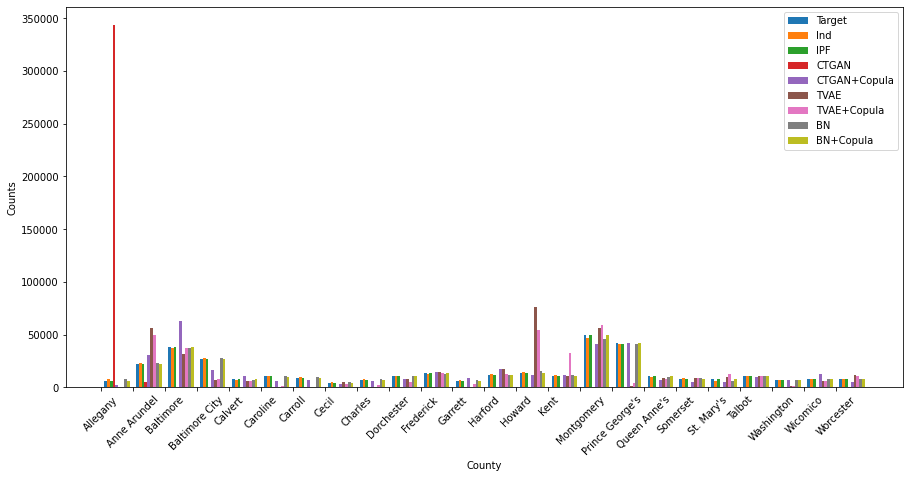

In [22]:
values = [v for v in mapping.values()]
keys = [k for k in mapping.keys()]

plt.figure(figsize=(15,7))
plt.hist(
    [target["COUNTY"]] + [synthetic[model]["COUNTY"] for model in synthetic],
    label=["Target"] + [f'{model}' for model in synthetic],
    bins=values+[values[-1]+1]
)
plt.xticks(
    values, 
    keys, 
    rotation=45
)
plt.xlabel("County")
plt.ylabel("Counts")
plt.legend()
plt.savefig("../results/figures/countymarginals.png",bbox_inches='tight')
plt.show()